In [104]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('chatgpt_reviews.csv')

In [3]:
df.head()

,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


In [4]:
df.shape

(196727, 4)

#### Check for null value 

In [5]:
df.isnull().sum()

Review Id      0
Review         6
Ratings        0
Review Date    0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

Review Id      0
Review         0
Ratings        0
Review Date    0
dtype: int64

#### we will add sentiment labels based on the review content.

In [8]:
from textblob import TextBlob

In [9]:
def get_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [10]:
df['Sentiment'] = df['Review'].apply(get_sentiment)

In [11]:
sentiment_distribution = df['Sentiment'].value_counts()

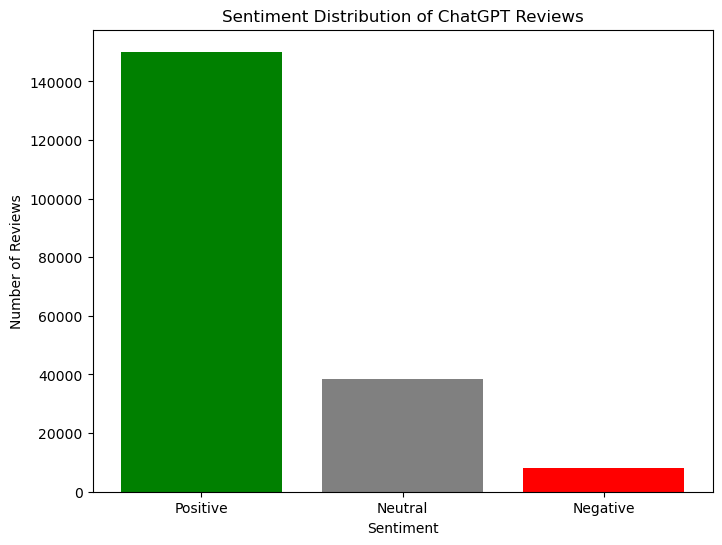

In [12]:
plt.figure(figsize=(8, 6))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution of ChatGPT Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

#### As we can see the majority of the reviews are positive, with a smaller proportion being neutral or negative. 

#### Exploring the Most Frequent Words
#### 1 st we will remove the stopwords from Review column and after that we will see which words are commom 

In [13]:
import nltk
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))  
punctuations = set(string.punctuation)  
def remove_stopwords(review):
    words = review.split() 
    filtered_words = [word for word in words if word.lower() not in stop_words and word not in punctuations]
    return " ".join(filtered_words) 


In [14]:
batch_size = 10000 
df['Cleaned_Review'] = ""  
for start in range(0, len(df), batch_size):
    end = start + batch_size
    df.loc[start:end, 'Cleaned_Review'] = df.loc[start:end, 'Review'].apply(remove_stopwords)


In [15]:
df.head()

,Review Id,Review,Ratings,Review Date,Sentiment,Cleaned_Review
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05,Positive,good
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18,Positive,good
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59,Positive,nice app
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50,Positive,"nice, ig"
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39,Positive,"great app, bot accurate anything, gives tips, ..."


In [16]:
from wordcloud import WordCloud
wc = WordCloud(width = 400,height = 500,min_font_size = 10,background_color = 'white')

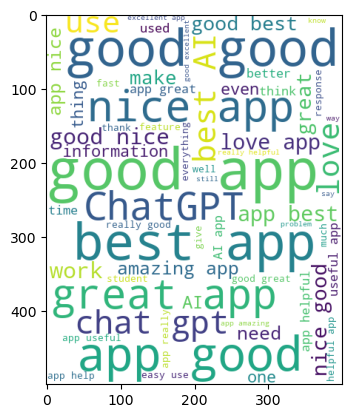

In [17]:
postive=wc.generate(df[df['Sentiment']=='Positive']['Cleaned_Review'].str.cat(sep=" "))
plt.imshow(postive)

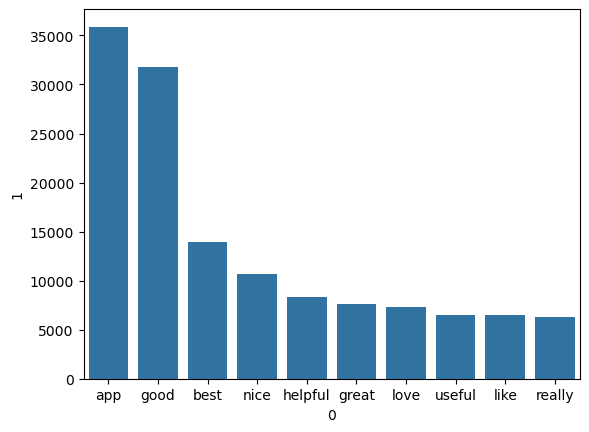

In [18]:
Postive = []
for msg in df[df['Sentiment']=='Positive']['Cleaned_Review'].tolist():
    for word in msg.split():
        Postive.append(word)
sns.barplot(x=pd.DataFrame(Counter(Postive).most_common(10))[0], y=pd.DataFrame(Counter(Postive).most_common(10))[1])
plt.show()

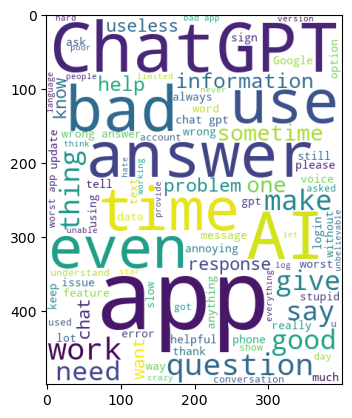

In [19]:
Negative=wc.generate(df[df['Sentiment']=='Negative']['Cleaned_Review'].str.cat(sep=" "))
plt.imshow(Negative)

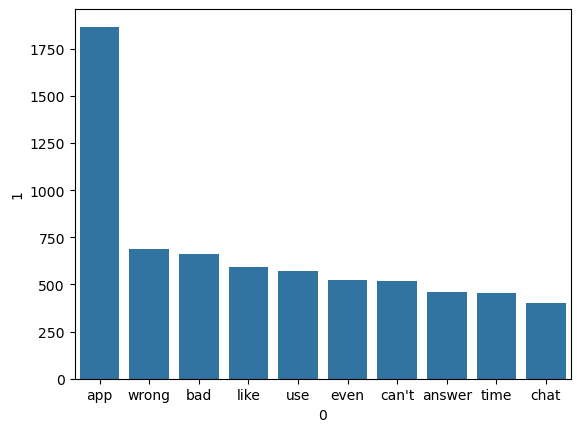

In [20]:
Negative = []
for msg in df[df['Sentiment']=='Negative']['Cleaned_Review'].tolist():
    for word in msg.split():
        Negative.append(word)
sns.barplot(x=pd.DataFrame(Counter(Negative).most_common(10))[0], y=pd.DataFrame(Counter(Negative).most_common(10))[1])
plt.show()

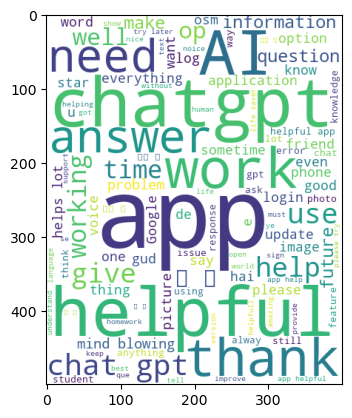

In [21]:
Neutral = wc.generate(df[df['Sentiment']=='Neutral']['Cleaned_Review'].str.cat(sep=" "))
plt.imshow(Neutral)

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


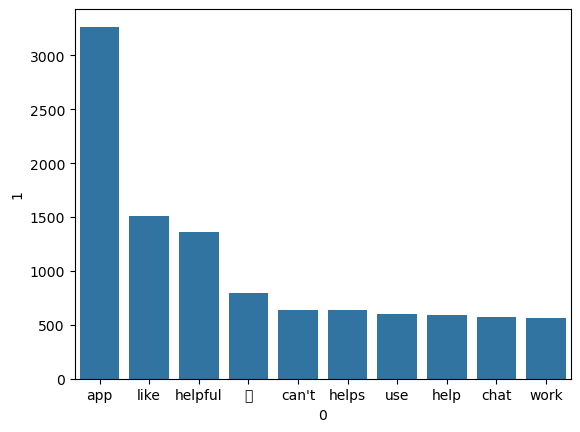

In [22]:
Neutral = []
for msg in df[df['Sentiment']=='Neutral']['Cleaned_Review'].tolist():
    for word in msg.split():
        Neutral.append(word)
sns.barplot(x=pd.DataFrame(Counter(Neutral).most_common(10))[0], y=pd.DataFrame(Counter(Neutral).most_common(10))[1])
plt.show()

### Exploring Monthly Changes in Review Sentiments

In [23]:
df['Review Date'] = pd.to_datetime(df['Review Date'])

In [24]:
reviews_per_month = df.groupby(df['Review Date'].dt.to_period('M')).size()
reviews_per_month = reviews_per_month.reset_index(name='Count')

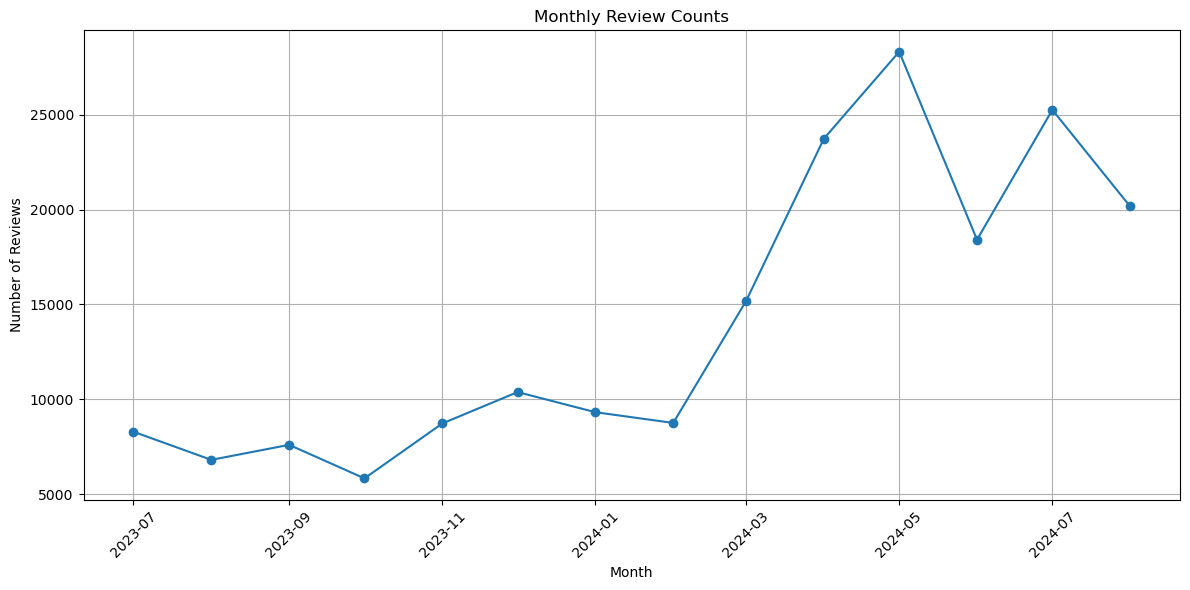

In [25]:
reviews_per_month['Review Date'] = reviews_per_month['Review Date'].dt.to_timestamp()
plt.figure(figsize=(12, 6))
plt.plot(reviews_per_month['Review Date'], reviews_per_month['Count'], marker='o')
plt.title('Monthly Review Counts')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

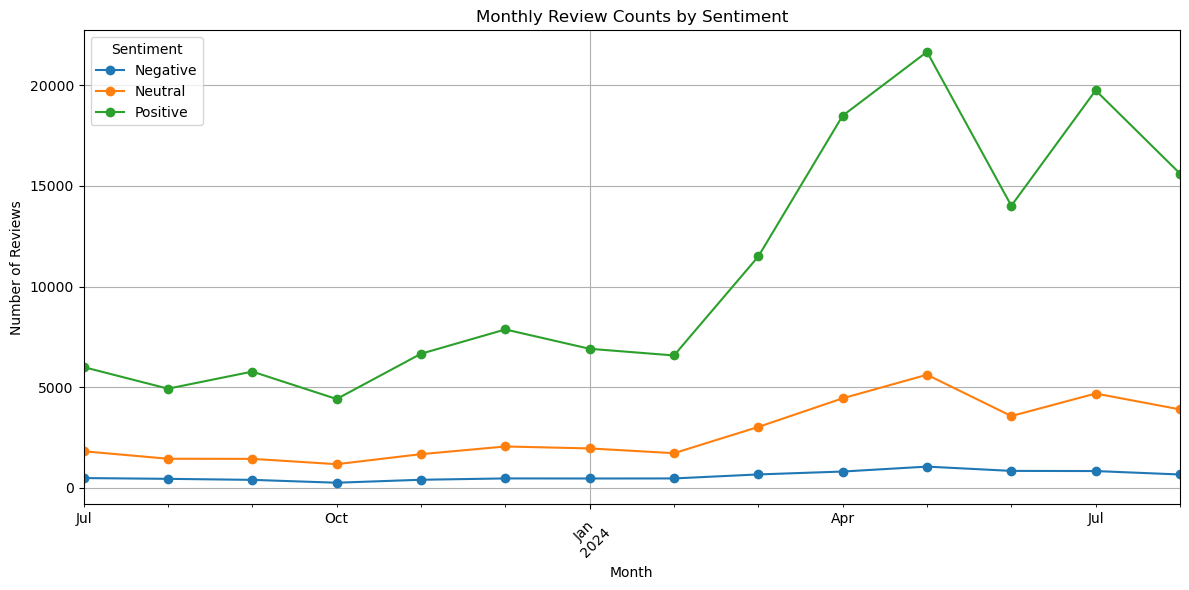

In [26]:
monthly_sentiment_counts = df.groupby([df['Review Date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)
monthly_sentiment_counts.index = monthly_sentiment_counts.index.to_timestamp()
monthly_sentiment_counts.plot(marker='o', figsize=(12, 6))
plt.title('Monthly Review Counts by Sentiment')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [27]:
df.head()

,Review Id,Review,Ratings,Review Date,Sentiment,Cleaned_Review
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05,Positive,good
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18,Positive,good
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59,Positive,nice app
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50,Positive,"nice, ig"
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39,Positive,"great app, bot accurate anything, gives tips, ..."


### Explore the relationship between the numerical ratings and the sentiment 

In [28]:
df['Ratings'].value_counts()

Ratings
5    150212
4     22897
1     12080
3      8157
2      3375
Name: count, dtype: int64

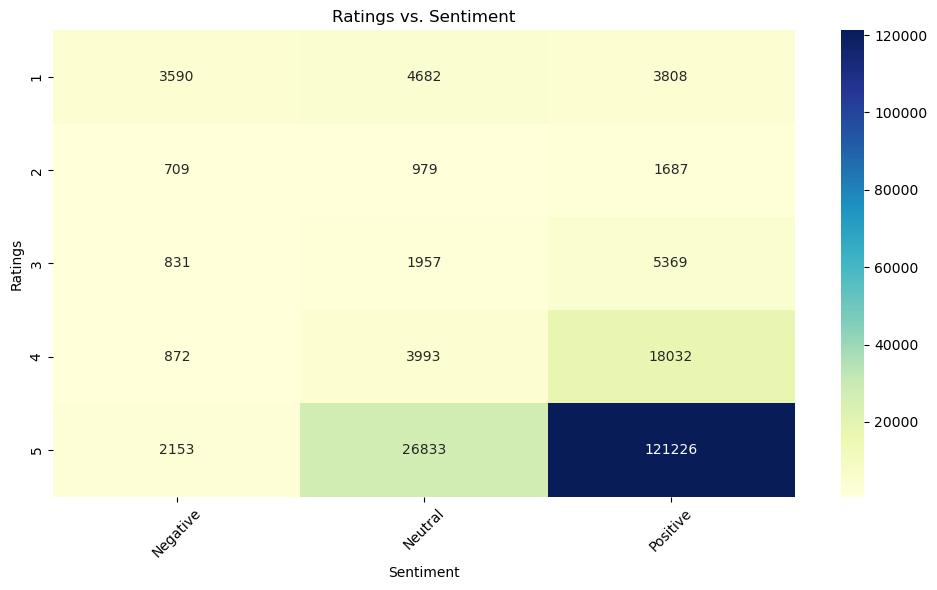

In [29]:
ratings_sentiment_counts = df.groupby(['Ratings', 'Sentiment']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(ratings_sentiment_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Ratings vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Total Ratings

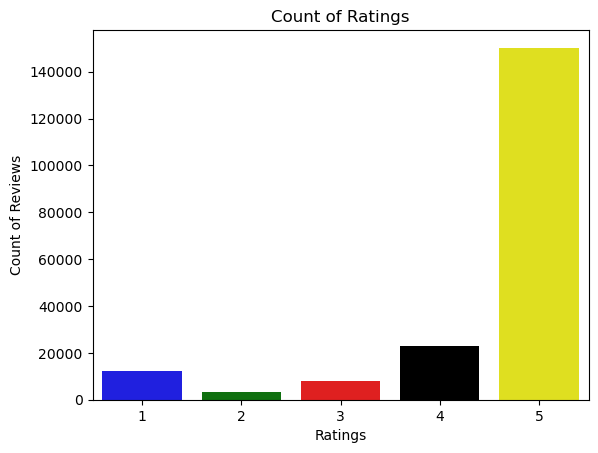

In [105]:
rating_counts = df['Ratings'].value_counts().sort_index()
sns.barplot(x=rating_counts.index,y=rating_counts.values,palette=['blue', 'green', 'red', 'black', 'yellow'])
plt.title('Count of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count of Reviews')
plt.show()

### Review Length Analysis

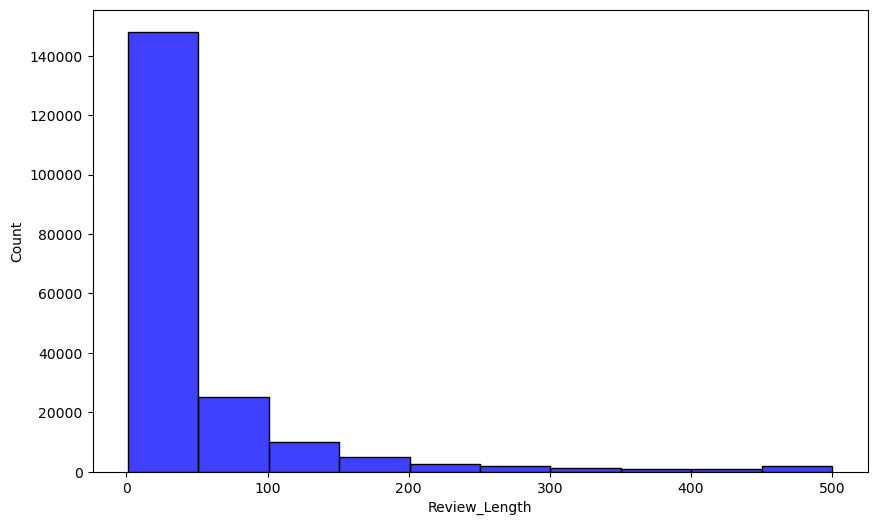

In [31]:
df['Review_Length'] = df['Review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['Review_Length'], bins=10, color='blue')
plt.show()

### average review lengths by sentiment

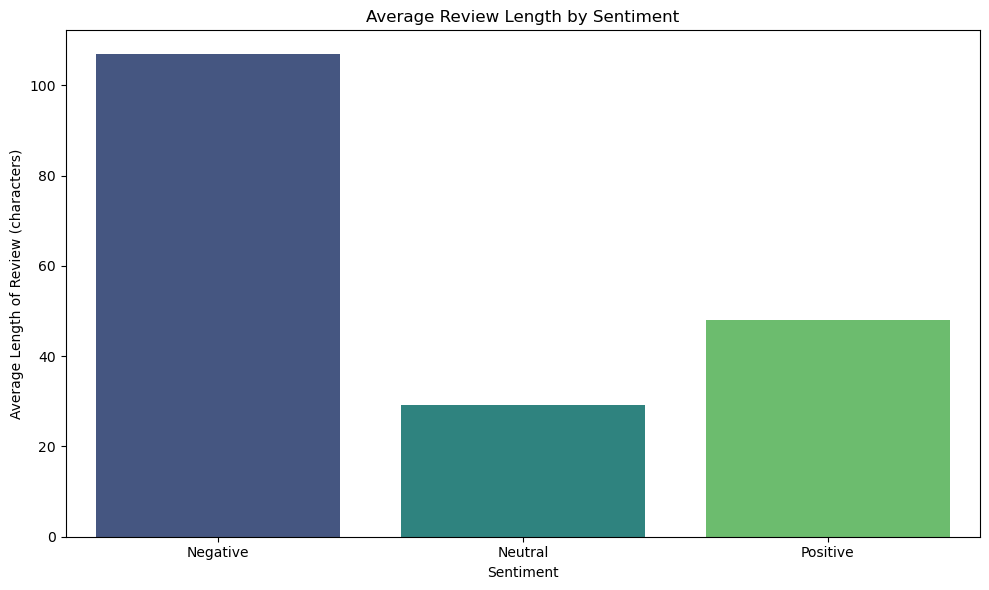

In [106]:
average_length_by_sentiment = df.groupby('Sentiment')['Review_Length'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='Review_Length', data=average_length_by_sentiment, palette='viridis')
plt.title('Average Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Length of Review (characters)')
plt.tight_layout()
plt.show()

<Figure size 700x800 with 0 Axes>

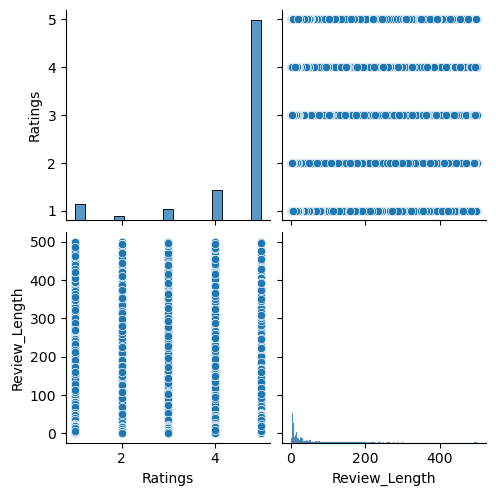

In [33]:
plt.figure(figsize=(7,8))
sns.pairplot(df[['Ratings', 'Review_Length']])
plt.show()

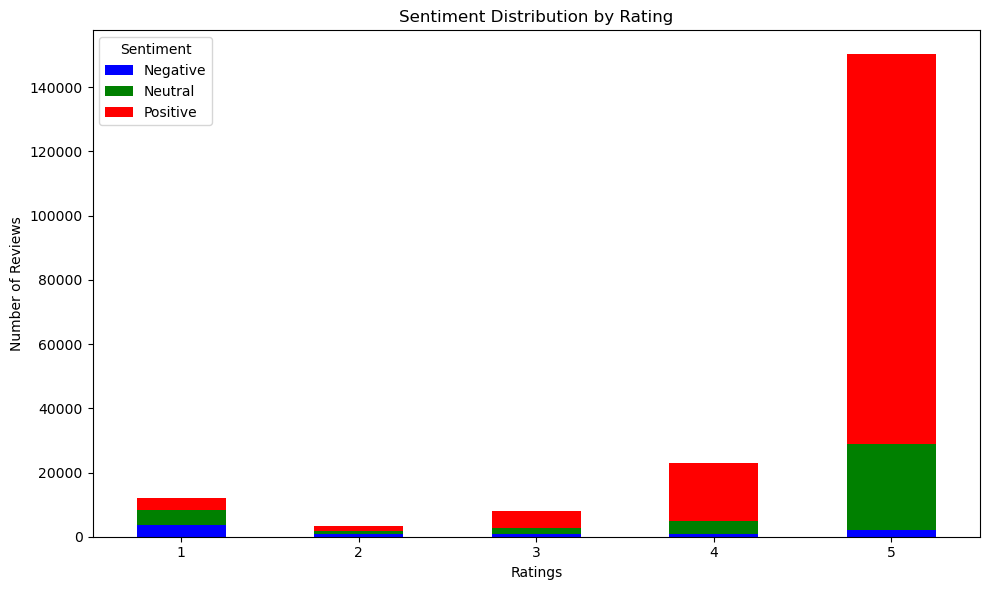

In [34]:
sentiment_counts = df.groupby(['Ratings', 'Sentiment']).size().unstack(fill_value=0)

# Step 2: Plot the results
sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'green', 'red'])
plt.title('Sentiment Distribution by Rating')
plt.xlabel('Ratings')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

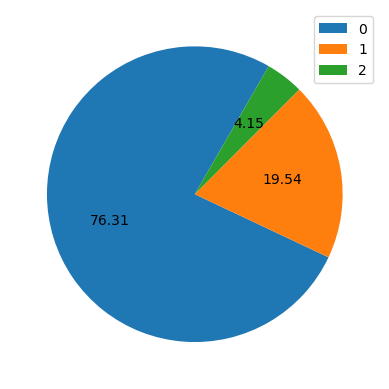

In [68]:
plt.pie(df['Sentiment'].value_counts(),autopct='%0.2f',startangle=60)
plt.legend(df['Sentiment'].index)
plt.show()

## We will bulid the model for Sentiment analysis

In [37]:
lab = LabelEncoder()

In [38]:
df['new_sentiment']=lab.fit_transform(df['Sentiment'])

In [39]:
df.head()

,Review Id,Review,Ratings,Review Date,Sentiment,Cleaned_Review,Review_Length,new_sentiment
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05,Positive,good,4,2
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18,Positive,good,4,2
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59,Positive,nice app,8,2
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50,Positive,"nice, ig",8,2
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39,Positive,"great app, bot accurate anything, gives tips, ...",368,2


In [53]:
X_review = df['Review']
X_rating = df[['Ratings']] 
y = df['new_sentiment']  
vectorizer = TfidfVectorizer()
X_review_tfidf = vectorizer.fit_transform(X_review)
X_rating_sparse = X_rating.values
X = hstack([X_review_tfidf, X_rating_sparse])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [107]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [62]:
model.score(X_train,y_train)*100

95.58954351362343

In [63]:
model.score(X_test,y_test)*100

95.25479730588384

In [101]:
def map_sentiment_label(prediction):
    if prediction == 0:
        return 'Negative'
    elif prediction == 1:
        return 'Neutral'
    elif prediction == 2:
        return 'Positive'


def predict_sentiment(review, rating):
    global vectorizer, model  
    review_vector = vectorizer.transform([review])
    review_with_rating = np.hstack([review_vector.toarray(), np.array([[rating]])])
    predicted_numeric_sentiment = model.predict(review_with_rating)[0]
    sentiment_label = map_sentiment_label(predicted_numeric_sentiment)
    return sentiment_label
    
predict_sentiment('worst app i ever saw in my life ', 1)


'Negative'

## we are creating another function for checking probabilty 

In [103]:
def predict_sentiment_with_proba(review, rating):
    global vectorizer, model  
    review_vector = vectorizer.transform([review])
    review_with_rating = np.hstack([review_vector.toarray(), np.array([[rating]])])
    predicted_probabilities = model.predict_proba(review_with_rating)[0]  
    predicted_numeric_sentiment = np.argmax(predicted_probabilities)
    sentiment_label = map_sentiment_label(predicted_numeric_sentiment)
    return sentiment_label, predicted_probabilities

# Example usage:
sentiment, probabilities = predict_sentiment_with_proba('sometime it works good , sometime not ', 3)
print(f"Predicted Sentiment: {sentiment}")
print(f"Probabilities: Negative: {probabilities[0]}, Neutral: {probabilities[1]}, Positive: {probabilities[2]}")


Predicted Sentiment: Neutral
Probabilities: Negative: 0.08334511299803624, Neutral: 0.5959810934241487, Positive: 0.32067379357781495
